# Example 08: FranSys -- Diagnosis/Prognosis Architecture

FranSys (Framework for Nonlinear System identification) uses a two-phase
approach: a **diagnosis** RNN estimates the system's hidden state from an
initialization window, then a **prognosis** RNN predicts forward from that
state. This architecture handles variable initial conditions gracefully and
generalizes to unseen starting points.

## Prerequisites

This notebook builds on concepts from Examples 00-03. Make sure you understand
simulation mode (Example 02) and prediction mode (Example 03) before
proceeding.

## Setup

In [1]:
from tsfast.datasets.benchmark import create_dls_cascaded_tanks
from tsfast.prediction.fransys import FranSysLearner, FranSysCallback
from tsfast.learner.callbacks import TimeSeriesRegularizer
from tsfast.learner.losses import fun_rmse

## The Diagnosis/Prognosis Concept

Traditional RNNs start from a zero hidden state, which doesn't match
reality -- real systems are rarely at rest. FranSys addresses this with a
two-phase architecture:

- **Diagnosis phase** (first `init_sz` timesteps): The diagnosis RNN processes
  the initialization window of measured input+output data to estimate the
  system's internal state. The final hidden state captures where the system
  "is" at the end of the window.

- **Prognosis phase** (remaining timesteps): The prognosis RNN receives the
  diagnosis hidden state and predicts forward. It processes incoming input
  (and optionally output feedback) to generate predictions.

The two RNNs share the same hidden dimension but are trained jointly
end-to-end.

## The Cascaded Tanks Benchmark

The Cascaded Tanks system is a benchmark where water flows between two tanks
in series. It exhibits strong nonlinear behavior due to the square-root
relationship between water level and flow rate. The system has one input
(pump voltage) and one output (water level in the second tank).

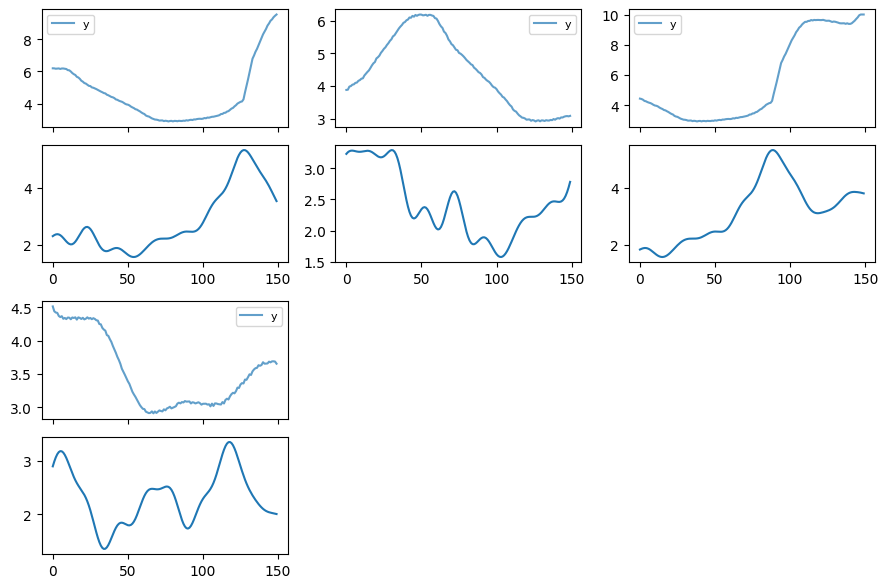

In [2]:
dls = create_dls_cascaded_tanks()
dls.show_batch(max_n=4)

## Training a Basic FranSys Model

Key parameters:

- **`init_sz=50`**: use the first 50 timesteps for diagnosis (state
  estimation). Predictions are only evaluated after this window.
- **`attach_output=True`**: activates PredictionCallback -- the model receives
  past measured outputs as additional input. This is standard for
  prediction-mode FranSys.
- **`hidden_size=40`**: dimension of the RNN hidden state for both diagnosis
  and prognosis.

In [3]:
lrn = FranSysLearner(
    dls, init_sz=50, attach_output=True,
    hidden_size=40, metrics=[fun_rmse]
)
lrn.fit_flat_cos(n_epoch=10, lr=3e-3)

epoch,train_loss,valid_loss,fun_rmse,time
0,0.438043,0.365791,0.838171,00:04
1,0.120095,0.256407,0.603637,00:04
2,0.087532,0.212123,0.525184,00:04
3,0.074213,0.197184,0.523674,00:03
4,0.076817,0.226682,0.509426,00:03
5,0.068405,0.191485,0.500401,00:03
6,0.064752,0.222185,0.509000,00:03
7,0.054969,0.237164,0.493421,00:03
8,0.040483,0.203590,0.491632,00:03
9,0.032437,0.221955,0.493469,00:03


## Visualize Results

`ds_idx=-1` shows the last validation/test set. The first 50 timesteps
(diagnosis window) are zero-padded because the model uses that region for
state estimation rather than prediction.

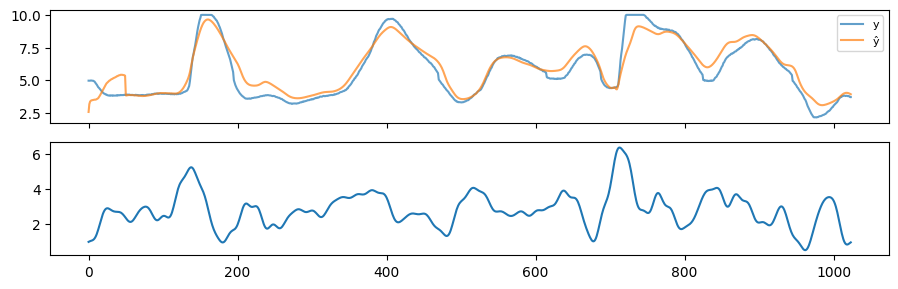

In [4]:
lrn.show_results(ds_idx=-1, max_n=2)

## Adding TimeSeriesRegularizer

FranSys models benefit significantly from activation regularization, which
encourages smoother predictions. `alpha` penalizes large activations, `beta`
penalizes abrupt changes between timesteps. We need to extract the prognosis
RNN module from the model so the regularizer knows which layer to hook into.

epoch,train_loss,valid_loss,fun_rmse,time
0,0.315234,0.331531,0.695330,00:03
1,0.159654,0.201287,0.527057,00:03
2,0.124614,0.212628,0.443714,00:03
3,0.102977,0.148776,0.277245,00:03
4,0.105973,0.121530,0.255781,00:03
5,0.087487,0.112102,0.191945,00:03
6,0.086224,0.138836,0.250739,00:03
7,0.076784,0.108382,0.172163,00:03
8,0.058619,0.118284,0.215821,00:03
9,0.046646,0.116379,0.210250,00:03


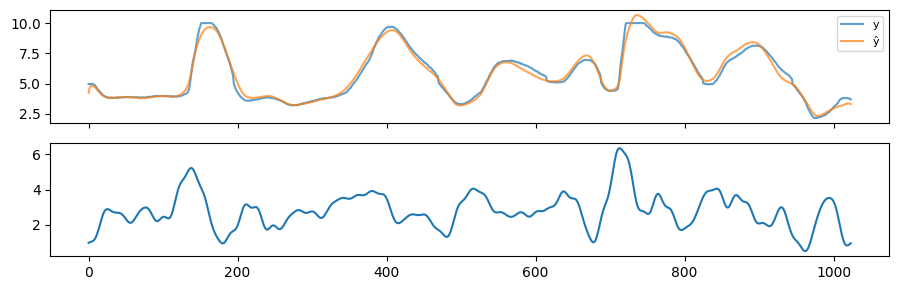

In [5]:
from tsfast.models.layers import unwrap_model

lrn_reg = FranSysLearner(
    dls, init_sz=50, attach_output=True,
    hidden_size=40, metrics=[fun_rmse]
)
model_reg = unwrap_model(lrn_reg.model)
lrn_reg.fit_flat_cos(n_epoch=10, lr=3e-3, cbs=[
    TimeSeriesRegularizer(alpha=6.0, beta=6.0, modules=[model_reg.rnn_prognosis])
])
lrn_reg.show_results(ds_idx=-1, max_n=2)

## FranSys Callback for State Synchronization

`FranSysCallback` adds an auxiliary loss that encourages the prognosis RNN to
maintain state consistency: the hidden state at any point in the prognosis
should be similar to what the diagnosis RNN would produce from the same data
window. This improves long-horizon stability.

The callback requires the diagnosis and prognosis modules to be passed
explicitly so it can hook into both and compare their hidden states.

epoch,train_loss,valid_loss,fun_rmse,time
0,1.923607,1.019177,1.283867,00:04
1,0.691201,0.349757,0.694443,00:04
2,0.325751,0.273137,0.634880,00:04
3,0.253182,0.284975,0.666837,00:04
4,0.220064,0.295359,0.697261,00:03
5,0.231199,0.251795,0.596009,00:03
6,0.208389,0.264894,0.644721,00:03
7,0.194298,0.266742,0.499743,00:03
8,0.137429,0.226431,0.439681,00:04
9,0.117001,0.204999,0.389418,00:03


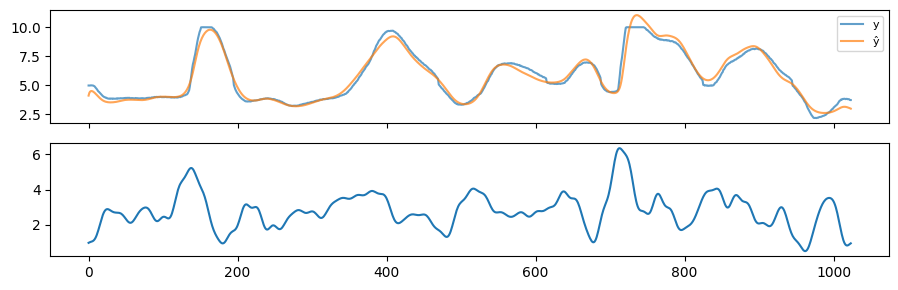

In [6]:
lrn_sync = FranSysLearner(
    dls, init_sz=50, attach_output=True,
    hidden_size=40, metrics=[fun_rmse]
)
model_sync = unwrap_model(lrn_sync.model)
lrn_sync.fit_flat_cos(n_epoch=10, lr=3e-3, cbs=[
    TimeSeriesRegularizer(alpha=6.0, beta=6.0, modules=[model_sync.rnn_prognosis]),
    FranSysCallback(
        modules=[model_sync.rnn_diagnosis, model_sync.rnn_prognosis],
        model=model_sync,
    ),
])
lrn_sync.show_results(ds_idx=-1, max_n=2)

## Key Takeaways

- FranSys separates state estimation (diagnosis) from forward prediction
  (prognosis).
- `init_sz` controls how many timesteps are used to initialize the hidden
  state from measured data.
- `attach_output=True` enables prediction mode (output feedback).
- `TimeSeriesRegularizer` is especially important for FranSys -- it
  encourages smooth, stable predictions.
- `FranSysCallback` adds state synchronization regularization for improved
  long-horizon stability. It requires the diagnosis and prognosis modules
  to be passed so it can compare their hidden states.
- The architecture naturally handles variable initial conditions.